Here we study how number of pairs and their dissimilarity change with the sky area of lenses.

In [ ]:
%load_ext autoreload
%autoreload 2

# --- Standard Library ---
import copy
import os
from copy import deepcopy
from itertools import combinations
from multiprocessing import Pool, cpu_count

# --- Scientific / Numerical ---
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import norm

# --- Visualization ---
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import display, Markdown, Math
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm
import corner
from matplotlib.gridspec import GridSpec
from scipy.stats import gaussian_kde

# --- Astropy ---
from astropy import constants as const
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy.table import Table
from astropy.units import Quantity

# --- SLSim ---
import slsim.Deflectors as deflectors
import slsim.Pipelines as pipelines
import slsim.Sources as sources
from slsim.Lenses.lens import Lens
from slsim.Lenses.lens_pop import LensPop
from slsim.LOS.los_pop import LOSPop
from slsim.Plots.lens_plots import LensingPlots

# --- Lenstronomy / HierArc ---
import emcee
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from lenstronomy.LensModel.lens_model import LensModel
from hierarc.Sampling.ParamManager.cosmo_param import CosmoParam
from hierarc.Sampling.mcmc_sampling import MCMCSampler

# --- ChainConsumer ---
from chainconsumer import Chain, ChainConfig, ChainConsumer, PlotConfig, Truth
from chainconsumer.plotting import plot_contour

# --- Local Utilities ---
from pdspl_analysis_utils import normalize_data, get_pairs_table_PDSPL, kdtree_matching_n_dim, draw_lens_from_given_zs

# --- Matplotlib Style ---
plt.style.use("paper_style.mplstyle")

## Prepare LSST like samples for Single Visit, Y10, and 4MOST 

In [31]:
########################################################
### Load the GGL data table and apply selection cuts!
########################################################

sky_area = "20000.0"
GGL_data_table = Table.read(f"../data/FULL_LSST/GGL_{sky_area}_SQDEG_NON_SIS.fits", format='fits')
# sky_area = "10000.0"
# GGL_data_table = Table.read(f"../data/FULL_LSST/GGL_{sky_area}_SQDEG_NON_SIS_UNIQUE_DEFLECTORS.fits", format='fits')

contrast_mask = np.zeros(len(GGL_data_table), dtype=bool)
# ps_magnification_mask = np.zeros(len(GGL_data_table), dtype=bool)
for i in range(len(GGL_data_table)):
    
    # contrast mask
    all_vals = GGL_data_table['contrast_ratio_i'][i]
    all_vals = all_vals[~np.isnan(all_vals)]
    # get linear scale values
    all_vals = 10**(-0.4 * all_vals)
    contrast_mask[i] = np.all(all_vals > 2) # all images should have contrast ratio > 2

    # point source magnification mask
    # ps_magnifications = GGL_data_table['ps_magnification'][i]
    # ps_magnifications = ps_magnifications[~np.isnan(ps_magnifications)]
    # high_mag = np.any(np.abs(ps_magnifications) > 3)
    # ps_magnification_mask[i] = high_mag

# add a column for r_band lensed source magnitude
GGL_data_table['mag_S_r_lensed'] = GGL_data_table['mag_S_r'] - 2.5 * np.log10(np.abs(GGL_data_table['es_magnification']))
GGL_data_table['mag_S_i_lensed'] = GGL_data_table['mag_S_i'] - 2.5 * np.log10(np.abs(GGL_data_table['es_magnification']))

# add g-r and r-i colors for deflector
GGL_data_table['color_D_gr'] = GGL_data_table['mag_D_g'] - GGL_data_table['mag_D_r']
GGL_data_table['color_D_ri'] = GGL_data_table['mag_D_r'] - GGL_data_table['mag_D_i']

# add log columns
GGL_data_table['log_R_e_kpc'] = np.log10(GGL_data_table['R_e_kpc'])
GGL_data_table['log_Sigma_half_Msun/pc2'] = np.log10(GGL_data_table['Sigma_half_Msun/pc2'])
GGL_data_table['log_sigma_v_D'] = np.log10(GGL_data_table['sigma_v_D'])

GGL_data_table = GGL_data_table[ 
                                # (GGL_data_table['mag_D_i'] >= 19) & # optional, but reasonable for realistic deflectors
                                (GGL_data_table['mag_S_i_lensed'] < 28)
                                & (GGL_data_table['mag_D_i'] < 28)
                                & (contrast_mask)
                                & (np.abs(GGL_data_table['es_magnification']) > 3)
                                # & (ps_magnification_mask)
                                ]

# remove duplicates
GGL_data_table = GGL_data_table[np.unique(GGL_data_table['z_D'], return_index=True)[1]]

GGL_data_table

<Table length=174131>
lens_id         z_D         ... log_Sigma_half_Msun/pc2   log_sigma_v_D   
 int64        float64       ...         float64              float64      
------- ------------------- ... ----------------------- ------------------
 297326 0.09478626100159085 ...       3.874184464593215  2.487207688339416
 473724 0.09957185525436509 ...       3.694415819635898 2.3825016285908607
 525732 0.10810877191097017 ...       3.585918154772145 2.3385299198403415
 142302 0.11148330036070185 ...      3.5624944477560243 2.4201814761084655
 118483 0.11307667288257063 ...       3.534006791471092 2.3506630455285813
 178316  0.1197214319724382 ...      3.7481416480722642  2.297946536196896
  39453 0.12047557628856939 ...      3.6102767560713565  2.209479462511367
  73930  0.1296800290990912 ...       3.797273758705501 2.3429401572815225
 584385 0.13245600052891762 ...      3.6959987191163015 2.3680654894159123
    ...                 ... ...                     ...                ...
 208223  2.4994863495875634 ...       4.111192118906513  2.712486711744956
 162758   2.499573558625508 ...      3.8946795337658338 2.5520401339112113
 292420   2.499584454451683 ...      3.7820412610796708  2.502889504488713
 343727  2.4995956753719724 ...       3.883581954003393 2.6047187739679294
 258681   2.499689615678387 ...       3.914922513343444  2.536864858572652
  79876  2.4997044447190526 ...      3.8097187700351833 2.5249059973492054
 348298  2.4997316632312967 ...       3.994515640451409  2.636886557961141
 124361  2.4997327097587076 ...       3.919808341210876 2.5304234371235355
  97274  2.4998097057614483 ...       3.761027720806669  2.663109876596368
 295209  2.4998713189652277 ...      3.7877302742673766 2.6936840590421007

In [32]:
########################################################
### Apply LSST magnitude depth cuts and produce pdspl_samples
########################################################

########################################################
# single exposure
# point source depths: g < 26.0, r < 25.7, i < 25.0, z < 24.3, y < 23.1
# extended source depths are 1 mag shallower: g < 25.0, r < 24.7, i < 24.0, z < 23.3, y < 22.1

# 10 year coadd
# point source depths: g < 27.4, r < 27.5, i < 26.8, z < 26.1, y < 24.9
# extended source depths are 1 mag shallower: g < 26.4, r < 26.5, i < 25.8, z < 25.1, y < 23.9

# 4MOST spec-z : r < 23.5 and z_S < 1.5

# 4MOST sigma_v_D : 50% of the spec-z sample will have sigma_v_D measurements, Collett et al 2023 [https://www.eso.org/sci/publications/messenger/archive/no.190-mar23/messenger-no190-49-52.pdf]
########################################################

# Define all LSST sample configurations in one structured dictionary
pdspl_samples = {
    # "slsim_20K_deg_sq.": {
    #     "mask": np.ones(len(GGL_data_table), dtype=bool),
    #     "title": f"SLSim Full Sample ({sky_area} deg$^2$)",
    #     "label": "SLSim Full Sample",
    #     "color": "tab:blue",
    #     "desc": "SLSim full sample; extended-source $i < 28.0$",
    #     "selc_func_latex": "$m_{i} < 28.0$"
    # },
    # "lsst_single_visit": {
    #     "mask": (
    #         (GGL_data_table["mag_D_i"] < 24.0)
    #         & (GGL_data_table["mag_S_i_lensed"] < 24.0)
    #         & (GGL_data_table["R_e_arcsec"] > 0.7) # added cut on R_e_arcsec > 0.7 arcsec at LSST seeing
    #     ),
    #     "title": f"LSST Single Visit Depth ({sky_area} deg$^2$)",
    #     "label": "LSST SINGLE ($i < 24.0$)",
    #     "name": "LSST SINGLE",
    #     "color": "tab:orange",
    #     "desc": "Single exposure; extended-source $i < 24.0$",
    #     "selc_func_latex": "$m_{i} < 24.0, R_e > 0.7''$"
    # },

    "lsst_y10": {
        "mask": (
            (GGL_data_table["mag_D_i"] < 25.8)
            & (GGL_data_table["mag_S_i_lensed"] < 25.8)
            & (GGL_data_table["R_e_arcsec"] > 0.7) # added cut on R_e_arcsec > 0.7 arcsec at LSST seeing
        ),
        "title": f"LSST 10-year Coadd Depth ({sky_area} deg$^2$)",
        "label": "LSST Y10 ($i < 25.8$)",
        "name": "LSST Y10",
        "color": "tab:green",
        "desc": "10-year coadd; extended-source $i < 25.8$",
        "selc_func_latex": "$m_{i} < 25.8, R_e > 0.7''$"
    },

    "lsst_4most_spec-z": {
        "mask": (
            (GGL_data_table["mag_S_r_lensed"] < 24.0) &
            (GGL_data_table["z_S"] < 1.5) &
            (GGL_data_table["R_e_arcsec"] > 0.7) # added cut on R_e_arcsec > 0.7 arcsec at LSST seeing
        ),
        "title": f"LSST + 4MOST spec-z Sample ({sky_area} deg$^2$)",
        "label": "LSST Y10 + 4MOST ($r < 24, z_S < 1.5$)",
        "name": "LSST Y10 + 4MOST (spec-z)",
        "color": "tab:red",
        "desc": "Spectroscopic 4MOST limit; $r < 24, z_S < 1.5$",
        "selc_func_latex": "$m_{r} < 24.0, z_S < 1.5, R_e > 0.7''$"
    },

    "lsst_4most_spec-z_sigma_v": {
        "mask": None,  # to be filled later, # half of the brightest 4MOST spec-z sample will have sigma_v measurements
        "title": f"LSST + 4MOST spec-z + "+"$\\sigma_{v, D}$"+f" Sample ({sky_area} deg$^2$)",
        "label": "LSST Y10 + 4MOST ($r < 24, z_S < 1.5$)",
        "name": "LSST Y10 + 4MOST (spec-z + $\\sigma_{v, D}$)",
        "color": "tab:purple",
        "desc": "Spectroscopic 4MOST limit; $r < 24, z_S < 1.5$",
        "selc_func_latex": "$m_{r} < 24.0, z_S < 1.5, R_e > 0.7''$"
    },
}

# Build filtered tables
for key, s in pdspl_samples.items():
    if key == 'lsst_4most_spec-z_sigma_v':
        org_mask = pdspl_samples['lsst_4most_spec-z']["mask"]
        # 50% of the brightest 4MOST spec-z sample will have sigma_v_D measurements
        brightest_indices = np.argsort(GGL_data_table['mag_D_i'])[:org_mask.sum() // 2]
        new_mask = np.zeros(len(GGL_data_table), dtype=bool)
        new_mask[brightest_indices] = True
        s["mask"] = new_mask

    s["table"] = GGL_data_table[s["mask"]]
    s["count"] = len(s["table"])

# Summary
print('-'*80)
print(f"Sky area: {sky_area} deg^2")
print('-'*80)
print(f"SLSim (i < 28, contrast_ratio > 2, mu_tot > 3, theta_E > 1\")  # lenses: {len(GGL_data_table)}")

for key, s in pdspl_samples.items():
    print(f"{s['name']:<62}# lenses: {s['count']}")

print('-'*80)

--------------------------------------------------------------------------------
Sky area: 20000.0 deg^2
--------------------------------------------------------------------------------
SLSim (i < 28, contrast_ratio > 2, mu_tot > 3, theta_E > 1")  # lenses: 174131
LSST Y10                                                      # lenses: 65729
LSST Y10 + 4MOST (spec-z)                                     # lenses: 1820
LSST Y10 + 4MOST (spec-z + $\sigma_{v, D}$)                   # lenses: 910
--------------------------------------------------------------------------------


In [33]:
# --- Cosmology used in SLSim and to use for forecasting ---
cosmology = "w0waCDM"  # Flat wCDM cosmology
# other options are: "FLCDM FwCDM", "w0waCDM", "oLCDM"
om_true = 0.3
w0_true = -1
wa_true = 0
h0_true = 70
kwargs_cosmo_true = {"h0": h0_true, "om": om_true, "w0": w0_true, "wa": wa_true}  # cosmological model of the forecast

cosmo_param = CosmoParam(cosmology=cosmology)
cosmo_true = cosmo_param.cosmo(kwargs_cosmo_true)

In [34]:
########################################################
### Pairing Properties and Titles
########################################################

# --- Deflector properties used for pairing ---
keys_to_pair_deflectors = [
    'z_D',
    'R_e_arcsec',
    'mag_D_i',
    'color_D_gr',
    'color_D_ri',
]

keys_to_pair_deflectors_latex = {
    'z_D': r'$z_{\mathrm{lens}}$',
    'R_e_kpc': r'$R_e$ [kpc]',
    'R_e_arcsec': r'$R_e$ [arcsec]',
    'mag_D_i': r'$m_i$',
    'color_D_gr': r'$m_g - m_r$',
    'color_D_ri': r'$m_r - m_i$',
    'sigma_v_D': r'$\sigma_{v, D}$ [km/s]',
} 

# assign pairing keys for each sample
for key, s in pdspl_samples.items():
    if key == 'lsst_4most_spec-z_sigma_v':
        pairing_keys = ['z_D', 'R_e_arcsec', 'sigma_v_D']
    else:
        pairing_keys = keys_to_pair_deflectors

    s['pairing_keys'] = pairing_keys
    s['pairing_title'] = "Paired w/ kD-Tree in " + ", ".join(
        [keys_to_pair_deflectors_latex[k] for k in pairing_keys]
    )
    s['pairing_keys_latex'] = ', '.join(
        [keys_to_pair_deflectors_latex[k] for k in pairing_keys]
    )

########################################################
## Adding errors on z_D and sigma_v_D and R_e_arcsec and magnitudes
##########################################################

for sample_key in pdspl_samples.keys():

    # z_D errors
    if sample_key in ['lsst_single_visit', 'lsst_y10']:    
        z_D_error = 0.03 * (1 + pdspl_samples[sample_key]['table']['z_D'])  # photometric redshift error from LSST Science Book
        sample_z_Ds_with_errors = pdspl_samples[sample_key]['table']['z_D'] + np.random.normal(loc=0, scale=z_D_error)
    elif sample_key in ['lsst_4most_spec-z', 'lsst_4most_spec-z_sigma_v']:
        z_D_error = 1e-4 # spectroscopic redshift error
        sample_z_Ds_with_errors = pdspl_samples[sample_key]['table']['z_D'] + np.random.normal(loc=0, scale=z_D_error)  
    else:
        z_D_error = 0
        sample_z_Ds_with_errors = pdspl_samples[sample_key]['table']['z_D']
    
    # sigma_v_D errors
    if sample_key == 'lsst_4most_spec-z_sigma_v':
        sigma_v_error = 10.0  # fixed 10 km/s error on sigma_v_D [https://ui.adsabs.harvard.edu/abs/2024MNRAS.527.5311L/abstract]
        sample_sigma_v_Ds_with_errors = pdspl_samples[sample_key]['table']['sigma_v_D'] + np.random.normal(loc=0, scale=sigma_v_error)
    else:
        sigma_v_error = 0
        sample_sigma_v_Ds_with_errors = pdspl_samples[sample_key]['table']['sigma_v_D']

    # R_e errors => 5-10% error on R_e
    R_e_error = 0.05 * (pdspl_samples[sample_key]['table']['R_e_arcsec'])
    sample_R_e_arcsec_with_errors = pdspl_samples[sample_key]['table']['R_e_arcsec'] + np.random.normal(loc=0, scale=R_e_error)

    # add these errors to a new table
    pdspl_samples[sample_key]['table_with_errors'] = pdspl_samples[sample_key]['table'].copy()
    pdspl_samples[sample_key]['table_with_errors']['z_D'] = sample_z_Ds_with_errors
    pdspl_samples[sample_key]['table_with_errors']['sigma_v_D'] = sample_sigma_v_Ds_with_errors
    pdspl_samples[sample_key]['table_with_errors']['R_e_arcsec'] = sample_R_e_arcsec_with_errors

    pdspl_samples[sample_key]['table_with_errors']['err_z_D'] = z_D_error
    pdspl_samples[sample_key]['table_with_errors']['err_sigma_v_D'] = sigma_v_error
    pdspl_samples[sample_key]['table_with_errors']['err_R_e_arcsec'] = R_e_error

    # # 5 millimag error on magnitudes
    # for band in ['g', 'r', 'i']:
    #     mag_band_error = 0.005 * pdspl_samples[sample_key]['table'][f'mag_D_{band}']
    #     sample_mag_band_with_errors = pdspl_samples[sample_key]['table'][f'mag_D_{band}'] + np.random.normal(loc=0, scale=mag_band_error)
    #     pdspl_samples[sample_key]['table_with_errors'][f'mag_D_{band}'] = sample_mag_band_with_errors   
    #     pdspl_samples[sample_key]['table_with_errors'][f'err_mag_D_{band}'] = mag_band_error
    

########################################################

########################################################
## OLD: define dissimilarity estimator parameters for each sample
##########################################################
# --- Define which parameters to include in the dissimilarity estimator ---
keys_to_use_for_dissimilarity = [
    "rel_diff_R_e_arcsec",
    "rel_diff_z_D",
    "rel_diff_mag_D_i",
    "rel_diff_color_D_gr",
    "rel_diff_color_D_ri"
]

# --- (optional) Define pretty LaTeX labels for each key ---
key_latex_map = {
    "rel_diff_R_e_arcsec": r"\frac{\Delta R_e}{R_e}",
    "rel_diff_z_D": r"\frac{\Delta z_D}{z_D}",
    "rel_diff_mag_D_i": r"\frac{\Delta m_i}{m_i}",
    "rel_diff_color_D_gr": r"\frac{\Delta c_{gr}}{c_{gr}}",
    "rel_diff_color_D_ri": r"\frac{\Delta c_{ri}}{c_{ri}}"
}

# assign dissimilarity keys for each sample
for key, s in pdspl_samples.items():
    if key == 'lsst_4most_spec-z_sigma_v':
        dissimilarity_keys = [
            "rel_diff_z_D",
            "rel_diff_R_e_arcsec",
            "rel_diff_sigma_v_D"
        ]
    else:
        dissimilarity_keys = keys_to_use_for_dissimilarity

    s['dissimilarity_keys'] = dissimilarity_keys
############################################################

# ########################################################
# ## NEW: define dissimilarity estimator parameters for each sample using z-scores
# ##########################################################
# # --- Define which parameters to include in the dissimilarity estimator ---
# keys_to_use_for_dissimilarity = [
#     "zscore_R_e_arcsec",
#     "zscore_z_D",
#     "zscore_mag_D_i",
#     "zscore_color_D_gr",
#     "zscore_color_D_ri"
# ]

# # assign dissimilarity keys for each sample
# for key, s in pdspl_samples.items():
#     if key == 'lsst_4most_spec-z_sigma_v':
#         dissimilarity_keys = [
#             "zscore_z_D",
#             "zscore_R_e_arcsec",
#             "zscore_sigma_v_D"
#         ]
#     else:
#         dissimilarity_keys = keys_to_use_for_dissimilarity

#     s['dissimilarity_keys'] = dissimilarity_keys
# ############################################################

########################################################
## define pairs selection function to select near-identical deflectors within 1 sigma [ZSCORE SIGMA]
##########################################################
def select_near_identical_deflectors(pairing_keys, pairs_table_with_errors, sigma = 0.02):
    # pairs table contains errors on z_D, sigma_v_D, R_e_arcsec

    z_D1 = pairs_table_with_errors['z_D1']
    z_D2 = pairs_table_with_errors['z_D2']
    err_z_D1 = pairs_table_with_errors['err_z_D1']
    err_z_D2 = pairs_table_with_errors['err_z_D2']

    sigma_v_D1 = pairs_table_with_errors['sigma_v_D1']
    sigma_v_D2 = pairs_table_with_errors['sigma_v_D2']
    err_sigma_v_D1 = pairs_table_with_errors['err_sigma_v_D1']
    err_sigma_v_D2 = pairs_table_with_errors['err_sigma_v_D2']

    R_e_arcsec_1 = pairs_table_with_errors['R_e_arcsec_D1']
    R_e_arcsec_2 = pairs_table_with_errors['R_e_arcsec_D2']
    err_R_e_arcsec_1 = pairs_table_with_errors['err_R_e_arcsec_D1']
    err_R_e_arcsec_2 = pairs_table_with_errors['err_R_e_arcsec_D2']

    combined_mask = np.ones(len(pairs_table_with_errors), dtype=bool)

    if 'z_D' in pairing_keys:
        z_D_diff = np.abs(z_D1 - z_D2)
        z_D_err_combined = np.sqrt(err_z_D1**2 + err_z_D2**2)
        z_D_zscore = z_D_diff / z_D_err_combined

        combined_mask &= (z_D_zscore < sigma)
    
    if 'sigma_v_D' in pairing_keys:
        sigma_v_diff = np.abs(sigma_v_D1 - sigma_v_D2)
        sigma_v_err_combined = np.sqrt(err_sigma_v_D1**2 + err_sigma_v_D2**2)
        sigma_v_zscore = sigma_v_diff / sigma_v_err_combined

        combined_mask &= (sigma_v_zscore < sigma)
    
    if 'R_e_arcsec' in pairing_keys:
        R_e_diff = np.abs(R_e_arcsec_1 - R_e_arcsec_2)
        R_e_err_combined = np.sqrt(err_R_e_arcsec_1**2 + err_R_e_arcsec_2**2)
        R_e_zscore = R_e_diff / R_e_err_combined
        
        combined_mask &= (R_e_zscore < sigma)

    # z_D1 < z_S2 and z_D2 < z_S1
    z_S1 = pairs_table_with_errors['z_S1']
    z_S2 = pairs_table_with_errors['z_S2']
    combined_mask &= ( (z_D1 < z_S2) & (z_D2 < z_S1) )

    idxs = np.where(combined_mask)[0]

    return pairs_table_with_errors[idxs], idxs
########################################################

In [38]:
########################################################
###  Get pairs table for each LSST sample
########################################################

for sample_key, s in pdspl_samples.items():
    table = s["table"]

    if len(table) < 2:
        print(f"⚠️ Skipping {sample_key}: too few lenses ({len(table)})")
        continue

    # print(f"\nBuilding full pairs table for {s['name']} ...")

    pairing_keys = s['pairing_keys']
    pairing_title = s['pairing_title']

    # Normalized feature space, use table with errors for pairing
    points = np.stack(
        [normalize_data(s['table_with_errors'][pk], type='zscore') for pk in pairing_keys],
        axis=1
    )

    # Pair with KD-tree
    indices, _ = kdtree_matching_n_dim(points=points, n_neighbors=2, unique_pairs=True)

    # Build pairs table from kD-tree indices
    pairs_table = get_pairs_table_PDSPL(table, pair_indices=indices, cosmo=cosmo_true)
    pairs_table_with_errors = get_pairs_table_PDSPL(s['table_with_errors'], pair_indices=indices, cosmo=cosmo_true)

    print(f"len of pairs table before selecting near-identical deflectors: {len(pairs_table)}")

    # Select near-identical deflectors, in reality we will only have the table with errors to select pairs
    pairs_table_with_errors, idxs = select_near_identical_deflectors(
                                        pairing_keys= pairing_keys,
                                        pairs_table_with_errors= pairs_table_with_errors,
                                        sigma=1)
    pairs_table = pairs_table[idxs]

    print(f"len of pairs table after selecting near-identical deflectors: {len(pairs_table)}")


    # Compute summary stats
    num_lenses = len(table)
    num_pairs = len(pairs_table)
    beta_ratio = pairs_table["beta_E_pseudo"] / pairs_table["beta_E_DSPL"]
    # beta_ratio = pairs_table_with_errors["beta_E_pseudo"] / pairs_table_with_errors["beta_E_DSPL"]
    scatter_in_beta_E = np.std(1 - beta_ratio)
    mean_beta_ratio = np.mean(beta_ratio)
    median_beta_ratio = np.median(beta_ratio)

    # Store results inside the sample dict
    s["pairs_analysis"] = {
        "pairs_table": pairs_table,
        "pairs_table_with_errors": pairs_table_with_errors,
        "num_lenses": num_lenses,
        "num_pairs": num_pairs,
        "scatter_in_beta_E": scatter_in_beta_E,
        "mean_beta_ratio": mean_beta_ratio,
        "median_beta_ratio": median_beta_ratio,
        "pairing_keys": pairing_keys,
        "pairing_title": pairing_title,
        "pairing_points": points,
    }

    print(f"✅ {s['name']}: {num_pairs} pairs, scatter = {scatter_in_beta_E:.4f}")

########################################################
###  Find dissimilarity estimator for each LSST sample and attach to pairs table
########################################################
for sample_key, s in pdspl_samples.items():
    pairs_table_with_errors = s["pairs_analysis"]["pairs_table_with_errors"]
    diffs = np.array([pairs_table_with_errors[k] for k in s['dissimilarity_keys']])
    dissimilarity_estimator = np.sqrt(np.mean(diffs**2, axis=0))
    s["pairs_analysis"]["pairs_table_with_errors"]['dissimilarity'] = dissimilarity_estimator
########################################################

Processing pairs: 100%|██████████| 48662/48662 [00:06<00:00, 7939.42it/s]


len of pairs table before selecting near-identical deflectors: 48662
len of pairs table after selecting near-identical deflectors: 47513
✅ LSST Y10: 47513 pairs, scatter = 0.2247


Processing pairs: 100%|██████████| 1339/1339 [00:00<00:00, 8207.07it/s]


len of pairs table before selecting near-identical deflectors: 1339
len of pairs table after selecting near-identical deflectors: 8
✅ LSST Y10 + 4MOST (spec-z): 8 pairs, scatter = 0.1629


Processing pairs: 100%|██████████| 659/659 [00:00<00:00, 8058.40it/s]

len of pairs table before selecting near-identical deflectors: 659
len of pairs table after selecting near-identical deflectors: 12
✅ LSST Y10 + 4MOST (spec-z + $\sigma_{v, D}$): 12 pairs, scatter = 0.0469


In [44]:
pdspl_samples['lsst_4most_spec-z_sigma_v']['pairs_analysis']['pairs_table']

<Table length=12>
index_1 index_2 ...       rel_diff_z_D        rel_diff_gamma_pl  
 int64   int64  ...         float64                float64       
------- ------- ... ----------------------- ---------------------
     60      59 ...  -2.750029134701917e-05    0.1490417794762433
    206     207 ...   0.0002441641085715835    0.1247776455254406
    295     294 ...  -0.0001614255135976568  -0.15230709740106166
    430     432 ...   0.0005308233160065857   -0.1176747619603914
    444     442 ...  -0.0003128443272888982  -0.03799665648694014
    614     613 ... -0.00029428777904869704  -0.08062348845840982
    617     615 ... -0.00010844718479478215  -0.07088778875011752
    631     633 ...   0.0004041083811425494  -0.03656624714929206
    649     650 ...   6.693200705001968e-07   0.00644328959721725
    652     654 ...  0.00021357482107904174 -0.039941864589561095
    839     840 ...   4.998143503064344e-05  -0.05227136630748174
    843     842 ...  -0.0001240895826254177 -0.029047893826815507

LSST Y10                                    => 47513  pairs, 65729  lenses
LSST Y10 + 4MOST (spec-z)                   => 8      pairs, 1820   lenses
LSST Y10 + 4MOST (spec-z + $\sigma_{v, D}$) => 12     pairs, 910    lenses


/var/folders/4r/jq9w4fy92y9_bqzvdfk2d5h40000gn/T/ipykernel_85765/3475164657.py:117: RuntimeWarning: divide by zero encountered in log10
  np.log10(np.array(binned_scatter_beta_E)), 1, cov=True)


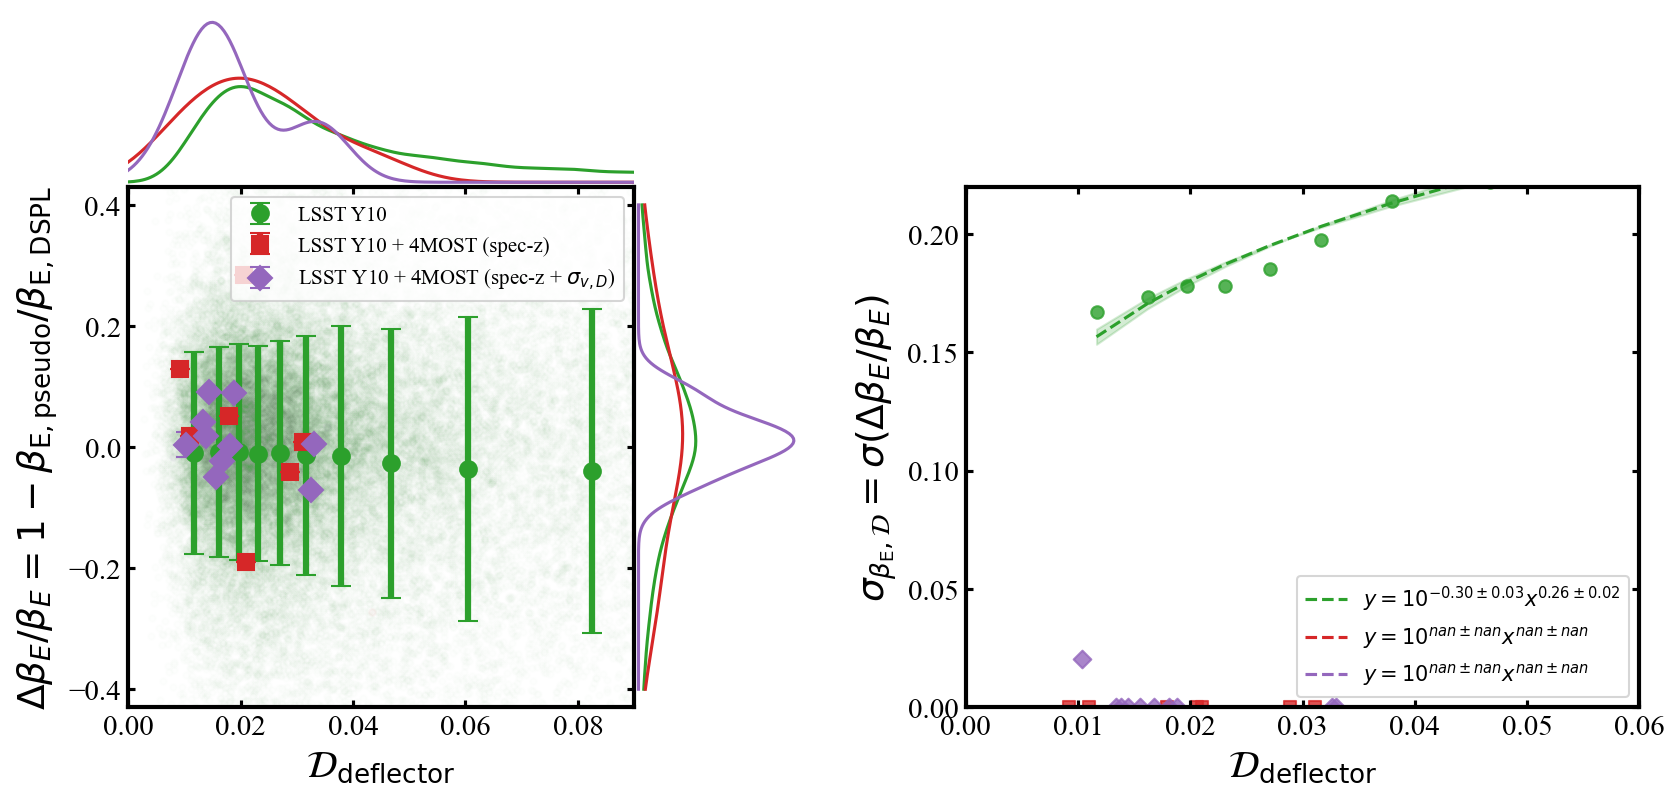

In [39]:
########################################
### scatter_beta_E as a function of dissimilarity
########################################

alpha_vals = {
    "lsst_y10": 0.007,
    "lsst_4most_spec-z": 0.03,
    "lsst_4most_spec-z_sigma_v": 0.04,
}

markers = {
    "lsst_y10": "o",
    "lsst_4most_spec-z": "s",
    "lsst_4most_spec-z_sigma_v": "D",
}

# percentile stepsizes for each sample
bins_stepsizes = {
    "lsst_y10": 10,
    "lsst_4most_spec-z": 10,
    "lsst_4most_spec-z_sigma_v": 10,
}

# --- Set up figure layout
fig = plt.figure(figsize=(13, 6))
gs = GridSpec(4, 9, figure=fig, wspace=-0.02, hspace=-0.02,
              )

ax_scatter = fig.add_subplot(gs[1:, 0:3])
ax_histx   = fig.add_subplot(gs[0, 0:3], sharex=ax_scatter)
ax_histy   = fig.add_subplot(gs[1:, 3], sharey=ax_scatter)
ax_fit = fig.add_subplot(gs[1:, 5:9])


# --- Loop through samples
for sample_key, s in pdspl_samples.items():
    tbl_err = s["pairs_analysis"]["pairs_table_with_errors"]
    tbl = s["pairs_analysis"]["pairs_table"]

    dissimilarities = tbl_err['dissimilarity']
    delta_beta_E = 1 - tbl['beta_E_pseudo'] / tbl['beta_E_DSPL']

    # limit to dissimilarity < 0.1 for better visualization
    mask = (tbl_err['dissimilarity'] < 0.1) & (np.isfinite(delta_beta_E))
    tbl_err = tbl_err[mask]
    tbl = tbl[mask]

    dissimilarities = tbl_err['dissimilarity']
    delta_beta_E = 1 - tbl['beta_E_pseudo'] / tbl['beta_E_DSPL']

    # Scatter
    ax_scatter.scatter(
        dissimilarities,
        delta_beta_E,
        color=s['color'],
        alpha=alpha_vals[sample_key],
        s=10,
    )

    # Histograms
    # ax_histx.hist(dissimilarities, bins=40, color=s['color'], histtype='step',
    #               density=True)
    # ax_histy.hist(delta_beta_E, bins=40, color=s['color'], orientation='horizontal', histtype='step',
    #               density=True)
    
    # --- KDE smoothed histograms
    kde_x = gaussian_kde(dissimilarities)
    kde_y = gaussian_kde(delta_beta_E)
    x_grid = np.linspace(0, 0.1, 200)
    y_grid = np.linspace(-0.4, 0.4, 200)
    ax_histx.plot(x_grid, kde_x(x_grid), color=s['color'], lw=1.5)
    ax_histy.plot(kde_y(y_grid), y_grid, color=s['color'], lw=1.5)

    
    # bin the dissimilarities, using percentiles, use np.digitize to bin
    percentiles = np.percentile(dissimilarities, np.arange(0, 101, bins_stepsizes[sample_key]))
    digitized = np.digitize(dissimilarities, percentiles)

    binned_dissimilarities = []
    binned_scatter_beta_E = []
    binned_means_beta_E = []

    for i in range(1, len(percentiles)):
        bin_mask = digitized == i
        if np.sum(bin_mask) > 0:
            binned_dissimilarities.append(np.median(dissimilarities[bin_mask]))
            scatter_in_beta_E = np.nanstd(delta_beta_E[bin_mask])
            binned_scatter_beta_E.append(scatter_in_beta_E)
            binned_means_beta_E.append(np.nanmean(delta_beta_E[bin_mask]))

    # on the original scatter plot, plot the binned means +- scatter
    ax_scatter.errorbar(
        binned_dissimilarities,
        binned_means_beta_E,
        yerr=binned_scatter_beta_E,
        fmt=markers[sample_key],
        color=s['color'],
        markersize=8,
        # markeredgecolor='k',
        label=s['name'],
        capsize=5,
        elinewidth=3,
    )

    # plot the binned scatter vs binned dissimilarity
    ax_fit.scatter(
        binned_dissimilarities,
        binned_scatter_beta_E,
        marker=markers[sample_key],
        color=s['color'],
        # label=s['name'],
        alpha=0.8,
    )
    
    # fit a line in log-log space, use covariance matrix to get uncertainties
    coeffs, cov = np.polyfit(np.log10(np.array(binned_dissimilarities)), 
                            np.log10(np.array(binned_scatter_beta_E)), 1, cov=True)
    
    # fit equation latex
    fit_eq_latex = r"$y = 10^{%.2f \pm %.2f} x^{%.2f \pm %.2f}$" % (
        coeffs[1], np.sqrt(cov[1, 1]),
        coeffs[0], np.sqrt(cov[0, 0])
    )

    # fitted line and 1-sigma uncertainty region
    ax_fit.plot(
        np.array(binned_dissimilarities),
        10**(np.polyval(coeffs, np.log10(np.array(binned_dissimilarities)))),
        linestyle='--',
        color=s['color'],
        label = fit_eq_latex
    )
    ax_fit.fill_between(
        np.array(binned_dissimilarities),
        10**(np.polyval(coeffs - np.sqrt(np.diag(cov)), np.log10(np.array(binned_dissimilarities)))),
        10**(np.polyval(coeffs + np.sqrt(np.diag(cov)), np.log10(np.array(binned_dissimilarities)))),
        color=s['color'],
        alpha=0.2,
    )

    # attach the fitted coeffs to the sample dict
    s['pairs_analysis']['scatter_vs_dissimilarity_fit_coeffs'] = coeffs

    # print the fit results
    print(f"{s['name']:<44}=> {s['pairs_analysis']['num_pairs']:<6} pairs, {len(s['table']):<6} lenses")
    
    

# --- Labels, limits, etc.
ax_scatter.set_xlabel(r"$\mathcal{D}_{\rm deflector}$")
ax_scatter.set_ylabel(r"$\Delta \beta_{E} / \beta_{E} = 1 - \beta_{\rm E, pseudo}/\beta_{\rm E, DSPL}$")
ax_scatter.set_xlim(0, 0.09)
ax_scatter.set_ylim(-0.43, 0.43)
ax_scatter.legend(frameon=True)

# --- Hide axis for the marginal histograms
ax_histx.axis('off')
ax_histy.axis('off')


# --- Fit panel axis labels
ax_fit.set_xlabel(r"$\mathcal{D}_{\rm deflector}$")
ax_fit.set_ylabel(r"$\sigma_{\beta_{\rm E},\rm \mathcal{D}} = \sigma(\Delta \beta_{E} / \beta_{E})$")
ax_fit.set_xlim(0, 0.06)
ax_fit.set_ylim(0, 0.22)
ax_fit.legend(frameon=True)


# --- Save figure
# fig.savefig(f"../figures/beta_E_vs_D.png", dpi=300, bbox_inches='tight')


In [24]:
########################################################
###  Scaling relation analysis for each LSST sample
########################################################

# --- Parameters ---
sky_areas = np.linspace(1000, 20000, 40)  # deg^2
fraction_of_max = sky_areas / max(sky_areas)

# --- Loop over all LSST samples ---
for sample_key, s in pdspl_samples.items():
    print(f"\nAnalyzing scaling relations for {s['label']} ...")

    table_full = s["table"]
    table_full_with_errors = s["table_with_errors"]

    # Skip empty tables
    if len(table_full_with_errors) < 2:
        print(f"⚠️  Skipping {sample_key} (too few lenses)")
        continue

    # Generate tables for different sky areas
    GGL_tables_at_different_sky_areas = {}
    GGL_tables_with_errors_at_different_areas = {}
    for area in sky_areas:
        num_rows = int(len(table_full_with_errors) * (area / max(sky_areas)))
        if num_rows < 2:
            continue
        indexes_ = np.random.choice(len(table_full_with_errors), num_rows, replace=False)
        subset_errors = table_full_with_errors[indexes_]
        subset = table_full[indexes_]
        GGL_tables_at_different_sky_areas[area] = subset
        GGL_tables_with_errors_at_different_areas[area] = subset_errors

    # Arrays to store results
    num_pairs_at_different_areas = []
    scatter_in_beta_E_at_different_areas = []
    num_lenses_at_different_sky_areas = []

    pairing_title = s['pairing_title']
    pairing_keys = s['pairing_keys']

    # --- Main scaling loop ---
    for area in sky_areas:
        if area not in GGL_tables_with_errors_at_different_areas:
            continue
        table = GGL_tables_at_different_sky_areas[area]
        table_errors = GGL_tables_with_errors_at_different_areas[area]

        # Normalize and pair
        points = np.stack(
            [normalize_data(table_errors[pk], type='zscore') for pk in pairing_keys],
            axis=1
        )
        indices, _ = kdtree_matching_n_dim(points=points, n_neighbors=2, unique_pairs=True)
        pairs_table = get_pairs_table_PDSPL(table, pair_indices=indices, cosmo=cosmo_true, progress_bar=False)

        num_pairs = len(pairs_table)
        num_lenses = len(table)
        scatter_in_beta_E = np.std(1 - pairs_table["beta_E_pseudo"] / pairs_table["beta_E_DSPL"])

        num_pairs_at_different_areas.append(num_pairs)
        scatter_in_beta_E_at_different_areas.append(scatter_in_beta_E)
        num_lenses_at_different_sky_areas.append(num_lenses)

    # --- Store results back into the sample dictionary ---
    s["scaling_results"] = {
        "sky_areas": sky_areas,
        "num_lenses": np.array(num_lenses_at_different_sky_areas),
        "num_pairs": np.array(num_pairs_at_different_areas),
        "scatter_in_beta_E": np.array(scatter_in_beta_E_at_different_areas),
        "pairing_keys": pairing_keys,
        "pairing_title": pairing_title,
    }

    print(f"✅ Finished {s['label']} | {len(s['scaling_results']['num_pairs'])} area bins processed.")
########################################################


Analyzing scaling relations for LSST Y10 ($i < 25.8$) ...


KeyboardInterrupt: 

In [8]:
########################################################
## Latex Table 1: Summary of all samples
## Columns: Sample, # Lenses, Selection Criteria
########################################################

print("Latex Table 1: Summary of all samples\n")

print(r"\begin{tabular}{l c c}")
print(r"\hline")
print(r"\textbf{Sample} & \textbf{\# Lenses} & \textbf{Selection Criteria}\\")
print(r"\hline")

# Main SLSim entry (spanning two rows)
print(
    f"\\multirow{{2}}{{*}}{{SLSim 20000 deg$^2$}} & "
    f"\\multirow{{2}}{{*}}{{{len(GGL_data_table)}}} & "
    + "$m_{i} < 28.0$, $\\mu_{\\rm tot} > 3$, $1'' < \\Delta \\theta < 8''$ \\\\"
)
print(r" & & contrast ratio $> 2$, $m_{i}^{\rm 2^{\rm nd} \ brightest} < 26$\\\\")

# Other samples
for key, s in pdspl_samples.items():
    print(f"{s['name']} & {s['count']} & {s['selc_func_latex']} \\\\")

print(r"\hline")
print(r"\end{tabular}")
########################################################


########################################################
## Latex Table 2: Pairing parameters per sample
## Columns: Sample, Pairing Parameters
########################################################

print("\nLatex Table 2: Pairing Parameters\n")

print(r"\begin{tabular}{l c}")
print(r"\hline")
print(r"\textbf{Sample} & \textbf{Pairing Parameters}\\")
print(r"\hline")

# Loop through paired samples
for key, s in pdspl_samples.items():
    print(f"{s['name']} & {s['pairing_keys_latex']} \\\\")

print(r"\hline")
print(r"\end{tabular}")
########################################################

Latex Table 1: Summary of all samples

\begin{tabular}{l c c}
\hline
\textbf{Sample} & \textbf{\# Lenses} & \textbf{Selection Criteria}\\
\hline
\multirow{2}{*}{SLSim 20000 deg$^2$} & \multirow{2}{*}{322403} & $m_{i} < 28.0$, $\mu_{\rm tot} > 3$, $1'' < \Delta \theta < 8''$ \\
 & & contrast ratio $> 2$, $m_{i}^{\rm 2^{\rm nd} \ brightest} < 26$\\\\
LSST SINGLE & 87505 & $m_{i} < 24.0, R_e > 0.7''$ \\
LSST Y10 & 153725 & $m_{i} < 25.8, R_e > 0.7''$ \\
LSST Y10 + 4MOST (spec-z) & 5113 & $m_{r} < 24.0, z_S < 1.5, R_e > 0.7''$ \\
LSST Y10 + 4MOST (spec-z + $\sigma_{v, D}$) & 2556 & $m_{r} < 24.0, z_S < 1.5, R_e > 0.7''$ \\
\hline
\end{tabular}

Latex Table 2: Pairing Parameters

\begin{tabular}{l c}
\hline
\textbf{Sample} & \textbf{Pairing Parameters}\\
\hline
LSST SINGLE & $z_{\mathrm{lens}}$, $R_e$ [arcsec], $m_i$, $m_g - m_r$, $m_r - m_i$ \\
LSST Y10 & $z_{\mathrm{lens}}$, $R_e$ [arcsec], $m_i$, $m_g - m_r$, $m_r - m_i$ \\
LSST Y10 + 4MOST (spec-z) & $z_{\mathrm{lens}}$, $R_e$ [arcsec],

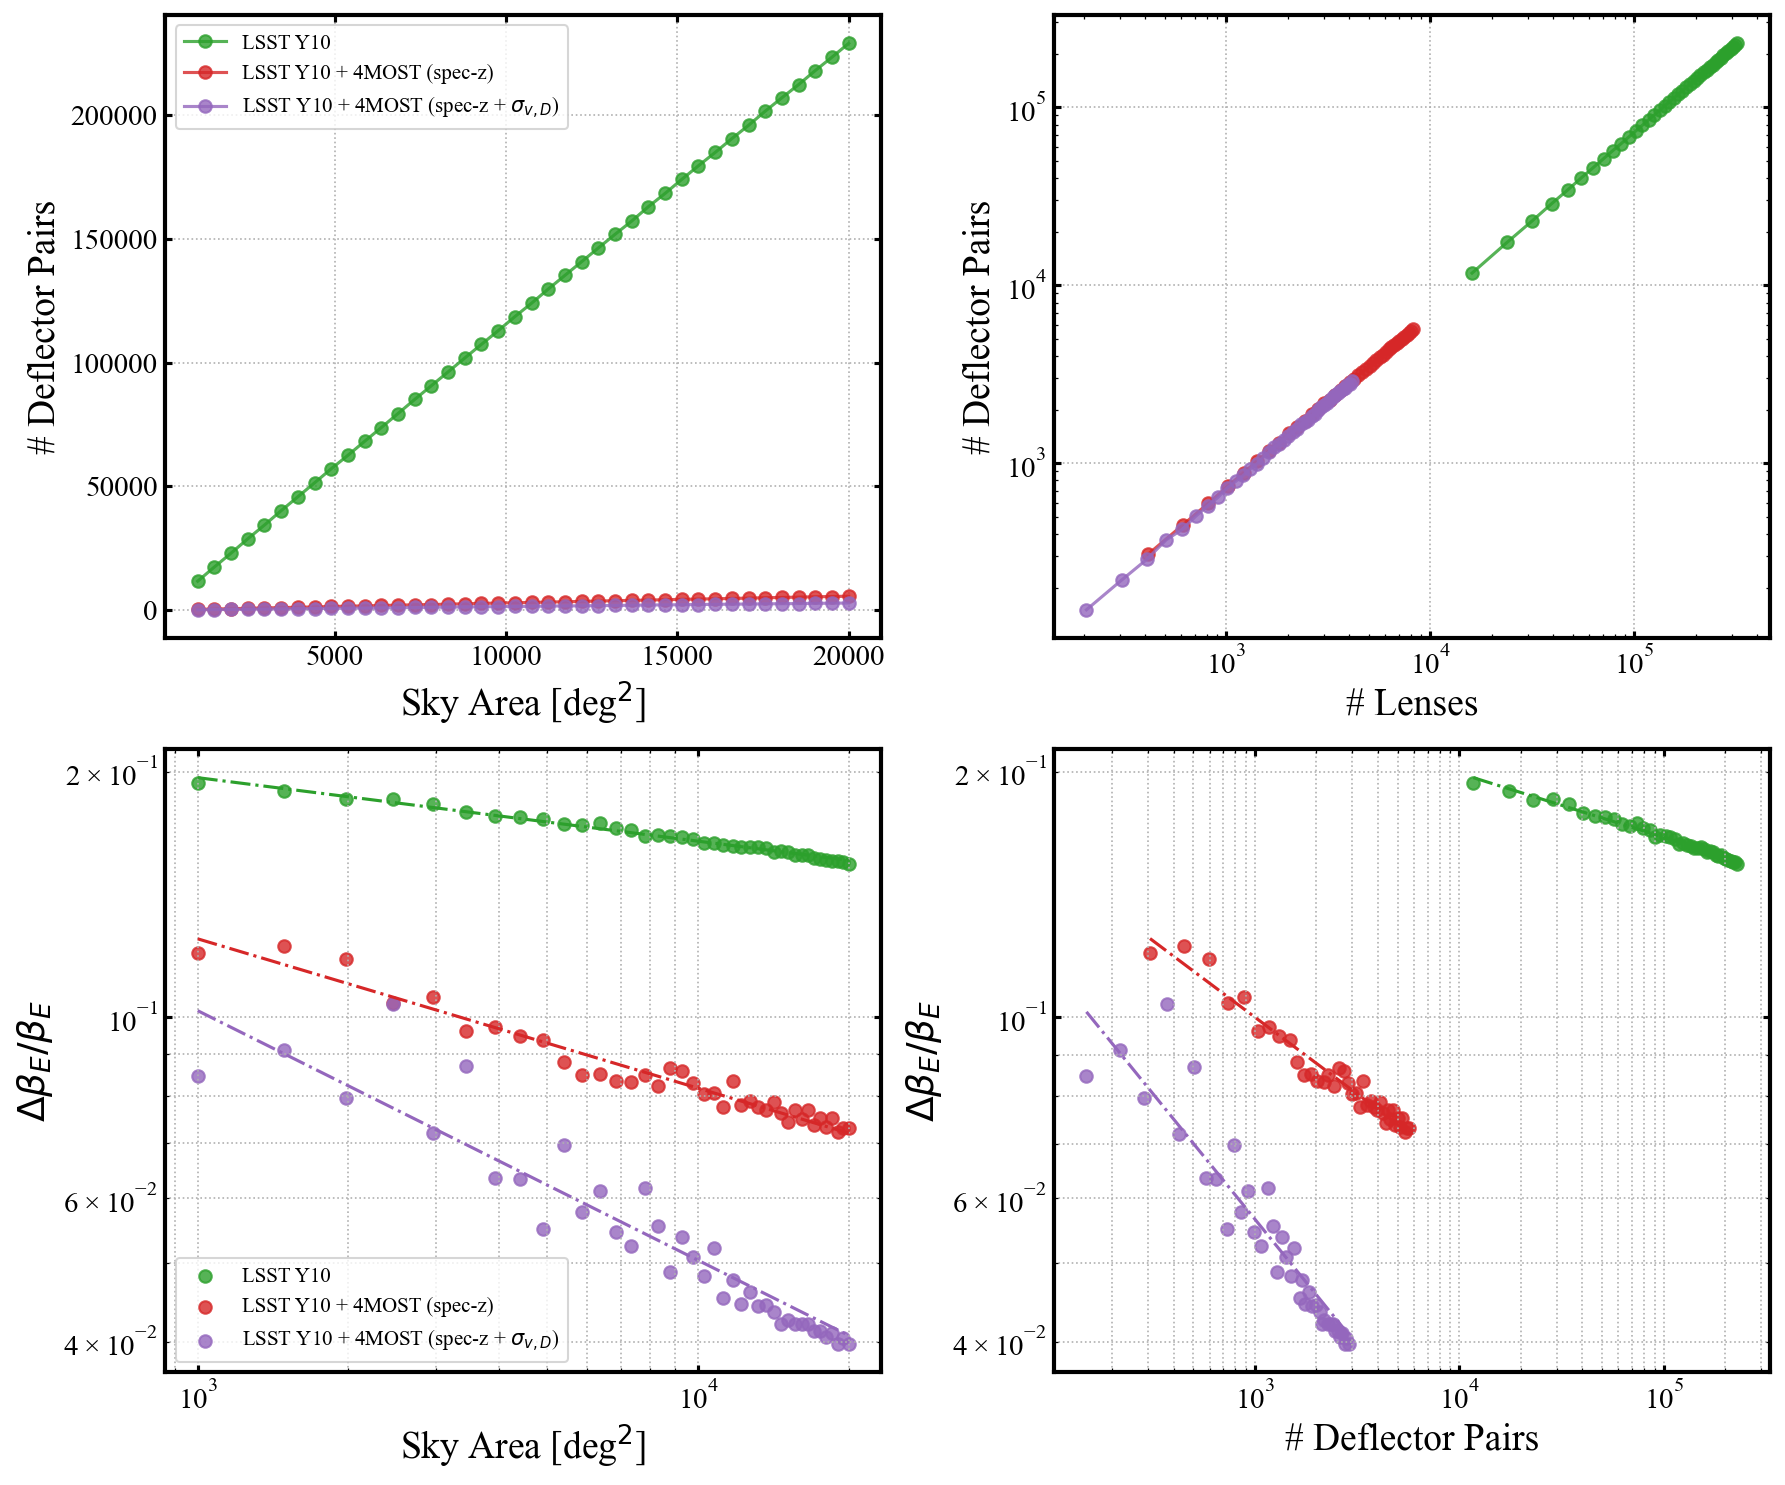

In [ ]:
########################################################
###  Multi-panel plots for scaling relations
########################################################

keys_to_plot = ["lsst_y10", 
                "lsst_4most_spec-z", 
                "lsst_4most_spec-z_sigma_v"]

def power_law(x, a, b):
    return a * x**b

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
(ax1, ax2), (ax3, ax4) = axes
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# --- Plot 1: # of deflector pairs vs sky area ---
for key in keys_to_plot:
    s = pdspl_samples[key]
    if "scaling_results" not in s: 
        continue
    sr = s["scaling_results"]
    ax1.plot(sr["sky_areas"], sr["num_pairs"], 
             label=s["name"], color=s["color"], marker='o', alpha=0.8)
ax1.set_xlabel("Sky Area [deg$^2$]")
ax1.set_ylabel("# Deflector Pairs")
# ax1.set_title("# of Deflector Pairs vs Sky Area")
ax1.legend()
ax1.grid(True, ls=':')

# --- Plot 2: # of deflector pairs vs number of lenses ---
for key in keys_to_plot:
    s = pdspl_samples[key]
    if "scaling_results" not in s:
        continue
    sr = s["scaling_results"]
    ax2.plot(sr["num_lenses"], sr["num_pairs"], 
             label=s["name"], color=s["color"], marker='o', alpha=0.8)
ax2.set_xlabel("# Lenses")
ax2.set_ylabel("# Deflector Pairs")
ax2.set_xscale("log")
ax2.set_yscale("log")
# ax2.set_title("# of Deflector Pairs vs # of Lenses")
ax2.grid(True, ls=':')

# --- Plot 3: scatter_in_beta_E vs sky area ---
for key in keys_to_plot:
    s = pdspl_samples[key]
    if "scaling_results" not in s:
        continue
    sr = s["scaling_results"]
    x = sr["sky_areas"]
    y = sr["scatter_in_beta_E"]

    ax3.scatter(x, y, color=s["color"], label=s["name"], alpha=0.8)
    
    # Fit a power law
    try:
        popt, _ = curve_fit(power_law, x, y, maxfev=10000)
        x_fit = np.linspace(min(x), max(x), 200)
        y_fit = power_law(x_fit, *popt)
        ax3.plot(x_fit, y_fit, ls='-.', color=s["color"])
    except:
        print(f"⚠️ Power law fit failed for {key}")

ax3.set_xlabel("Sky Area [deg$^2$]")
ax3.set_ylabel("${\\Delta \\beta_E}/{\\beta_E}$")
# ax3.set_title("Scatter in $\\beta_E$ vs Sky Area")
ax3.set_xscale("log")
ax3.set_yscale("log")
ax3.grid(True, which='both', ls=':')
ax3.legend()

# --- Plot 4: scatter_in_beta_E vs num of deflector pairs ---
for key in keys_to_plot:
    s = pdspl_samples[key]
    if "scaling_results" not in s:
        continue
    sr = s["scaling_results"]
    x = sr["num_pairs"]
    y = sr["scatter_in_beta_E"]

    ax4.scatter(x, y, color=s["color"], label=s["name"], alpha=0.8)
    
    # Fit a power law
    try:
        popt, _ = curve_fit(power_law, x, y, maxfev=10000)
        x_fit = np.linspace(min(x), max(x), 200)
        y_fit = power_law(x_fit, *popt)
        ax4.plot(x_fit, y_fit, ls='-.', color=s["color"])
    except:
        print(f"⚠️ Power law fit failed for {key}")
    
    # store fitting parameters
    pdspl_samples[key]['scaling_results']['power_law_fit_params_beta_E_vs_num_pairs'] = {
        'a': popt[0],
        'b': popt[1],
    }

ax4.set_xlabel("# Deflector Pairs")
ax4.set_ylabel("${\\Delta \\beta_E}/{\\beta_E}$")
# ax4.set_title("Scatter in $\\beta_E$ vs # of Deflector Pairs")
ax4.set_xscale("log")
ax4.set_yscale("log")
ax4.grid(True, which='both', ls=':')

fig.tight_layout()

# save the figure
# plt.savefig(f"../figures/slsim_all_samples_pairing_statistics.pdf", dpi=300)
# plt.savefig(f"../figures/slsim_all_samples_pairing_statistics.png", dpi=300)

In [8]:
print("\nLatex Table 3: Summary of Pairing Analysis Results\n")

keys_to_plot = ["lsst_y10", 
                "lsst_4most_spec-z", 
                "lsst_4most_spec-z_sigma_v"]

print(r"\begin{tabular}{l | c c c | c c}")
print(r"\hline")
print(r"\multirow{2}{*}{\textbf{Sample}} & \multicolumn{3}{c|}{\textbf{Pairing at 20K deg$^2$}} & \multicolumn{2}{c}{\textbf{PL Fit}} \\")
print(r" & \textbf{\# Lenses} & \textbf{\# Pairs} & \textbf{${\Delta\beta_{\rm E}}/{\beta_{\rm E}}$} & \textbf{a} & \textbf{b} \\")
print(r"\hline")

# Loop through paired samples
for key in keys_to_plot:
    s = pdspl_samples[key]
    if "pairs_analysis" not in s:
        continue
    pa = s["pairs_analysis"]
    fit_params = s['scaling_results']['power_law_fit_params_beta_E_vs_num_pairs']
    print(
        f"{s['name']} & "
        f"{pa['num_lenses']} & "
        f"{pa['num_pairs']} & "
        f"{pa['scatter_in_beta_E']:.4f} & "
        f"{fit_params['a']:.2f} & "
        f"{fit_params['b']:.2f} \\\\"
    )

print(r"\hline")
print(r"\end{tabular}")



Latex Table 3: Summary of Pairing Analysis Results

\begin{tabular}{l | c c c | c c}
\hline
\multirow{2}{*}{\textbf{Sample}} & \multicolumn{3}{c|}{\textbf{Pairing at 20K deg$^2$}} & \multicolumn{2}{c}{\textbf{PL Fit}} \\
 & \textbf{\# Lenses} & \textbf{\# Pairs} & \textbf{${\Delta\beta_{\rm E}}/{\beta_{\rm E}}$} & \textbf{a} & \textbf{b} \\
\hline


KeyError: 'scaling_results'

Plotting for LSST SINGLE ($i < 24.0$) with 63758 pairs
Plotting for LSST Y10 ($i < 25.8$) with 112071 pairs
Plotting for LSST Y10 + 4MOST ($r < 24, z_S < 1.5$) with 3663 pairs
Plotting for LSST Y10 + 4MOST ($r < 24, z_S < 1.5$) with 1788 pairs


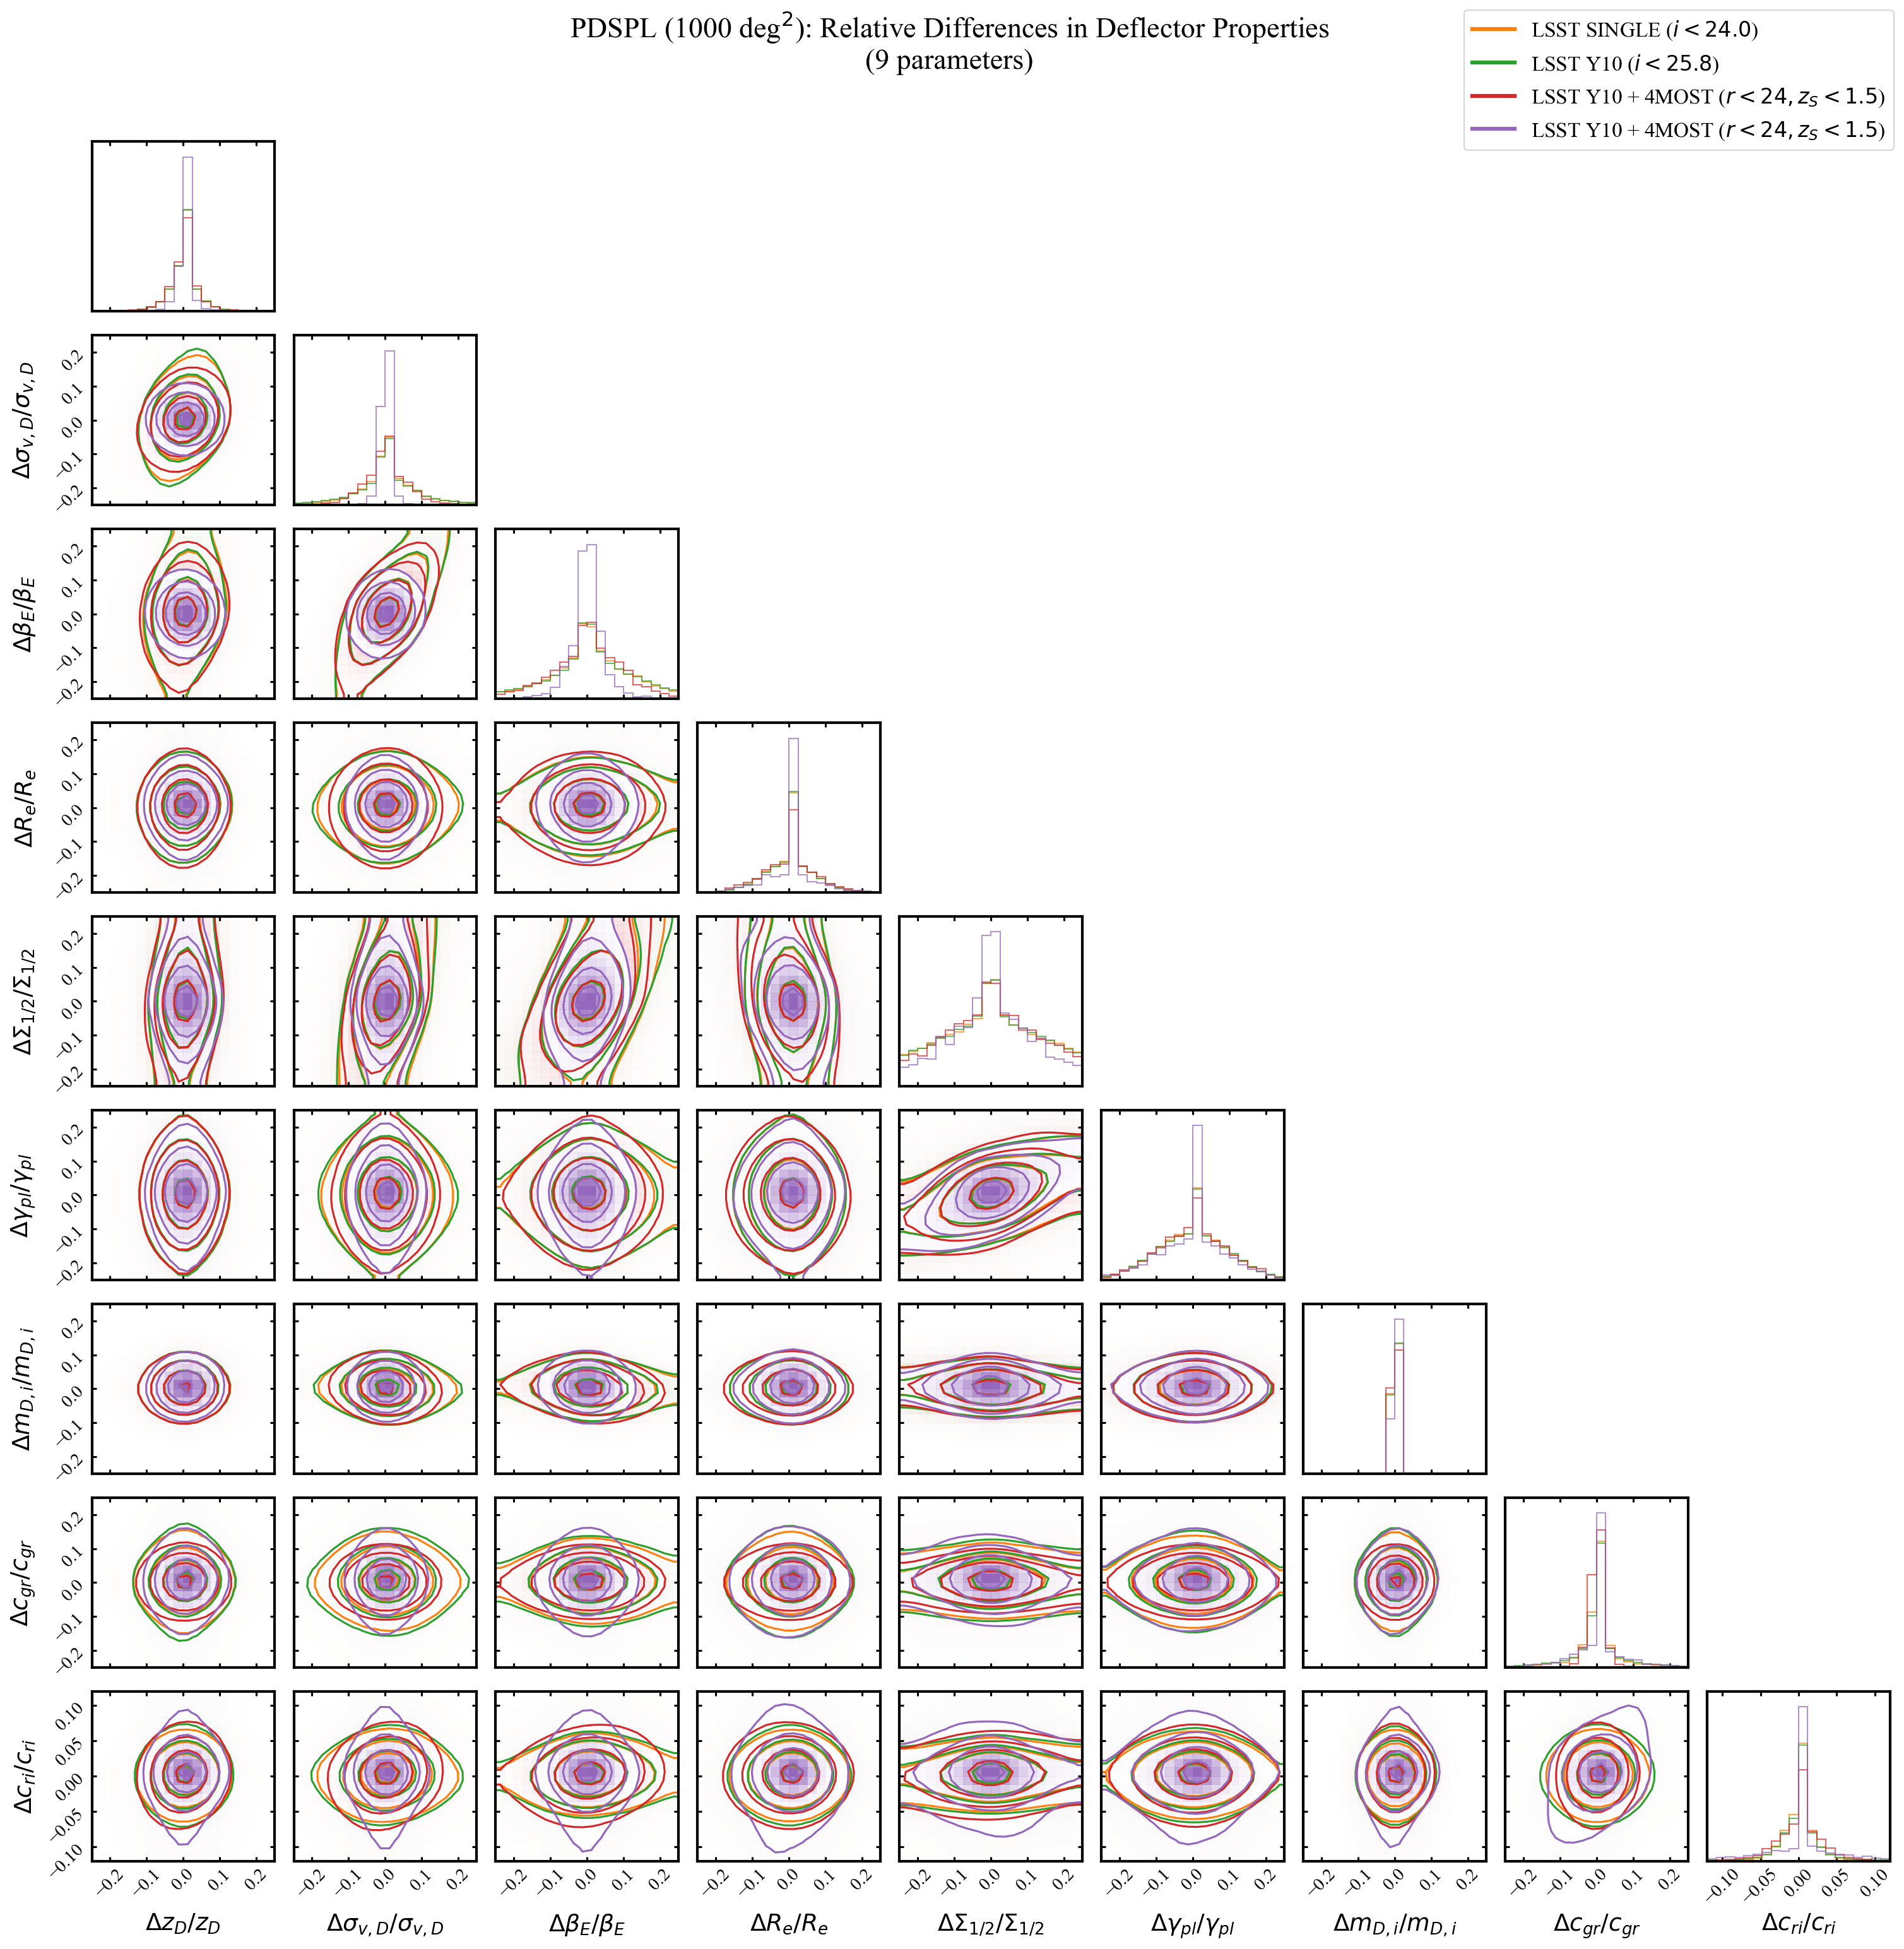

In [11]:
########################################################
###  Corner Plot for Deflector Pair Differences
########################################################

# --- Define which relative-difference parameters to include ---
keys_to_use_for_corner = [
    "rel_diff_z_D",
    "rel_diff_sigma_v_D",
    "rel_diff_beta_E",
    "rel_diff_R_e_arcsec",
    "rel_diff_Sigma_half",
    "rel_diff_gamma_pl",
    "rel_diff_mag_D_i",
    "rel_diff_color_D_gr",
    "rel_diff_color_D_ri"
]

# --- Define LaTeX labels dynamically for corner axes ---
key_latex_map = {
    "rel_diff_z_D":        r"$\Delta z_{D} / z_{D}$",
    "rel_diff_sigma_v_D":  r"$\Delta \sigma_{v,D} / \sigma_{v,D}$",
    "rel_diff_beta_E":     r"$\Delta \beta_{E} / \beta_{E}$",
    "rel_diff_R_e_arcsec": r"$\Delta R_{e} / R_{e}$",
    "rel_diff_Sigma_half": r"$\Delta \Sigma_{1/2} / \Sigma_{1/2}$",
    "rel_diff_gamma_pl":   r"$\Delta \gamma_{pl} / \gamma_{pl}$",
    "rel_diff_mag_D_i":    r"$\Delta m_{D,i} / m_{D,i}$",
    "rel_diff_color_D_gr": r"${\Delta c_{gr}} / {c_{gr}}$",
    "rel_diff_color_D_ri": r"${\Delta c_{ri}} / {c_{ri}}$"
}

corner_labels = [key_latex_map[k] for k in keys_to_use_for_corner]

# --- Which samples to plot ---
samples_to_plot = ["lsst_single_visit", "lsst_y10", 
                   "lsst_4most_spec-z", 
                   "lsst_4most_spec-z_sigma_v"]

# --- Plotting ---
figure = None  # will hold combined corner plot

for key in samples_to_plot:
    s = pdspl_samples[key]
    if "pairs_analysis" not in s:
        print(f"⚠️ Skipping {s['label']} (no pairs_analysis found)")
        continue

    pairs_table = s["pairs_analysis"]["pairs_table"]

    if len(pairs_table) == 0:
        print(f"⚠️ Skipping {s['label']} (no pairs found)")
        continue

    print(f"Plotting for {s['label']} with {len(pairs_table)} pairs")

    # --- Build corner data array dynamically ---
    corner_data = np.vstack([pairs_table[k] for k in keys_to_use_for_corner]).T

    figure = corner.corner(
        corner_data,
        labels=corner_labels,
        color=s["color"],
        fig=figure,                      # overlay all samples on same figure
        smooth=2.0,
        hist_kwargs={"density": True, "alpha": 0.7},
        plot_density=True,
        plot_datapoints=False,
        show_titles=False,
        label_kwargs={"fontsize": 18},
        range=[(-0.25, 0.25)] * (len(keys_to_use_for_corner) - 1) + [(-0.12, 0.12)],
    )

# --- Add legend manually ---
handles = [
    plt.Line2D([], [], color=pdspl_samples[k]["color"], lw=3, label=pdspl_samples[k]["label"])
    for k in samples_to_plot
]
figure.legend(handles=handles, loc="upper right", fontsize=16)

# --- Title & layout ---
figure.suptitle(
    f"PDSPL (1000 deg$^2$): Relative Differences in Deflector Properties\n"
    f"({len(keys_to_use_for_corner)} parameters)",
    fontsize=22,
    y=1.02
)
figure.tight_layout()
plt.show()

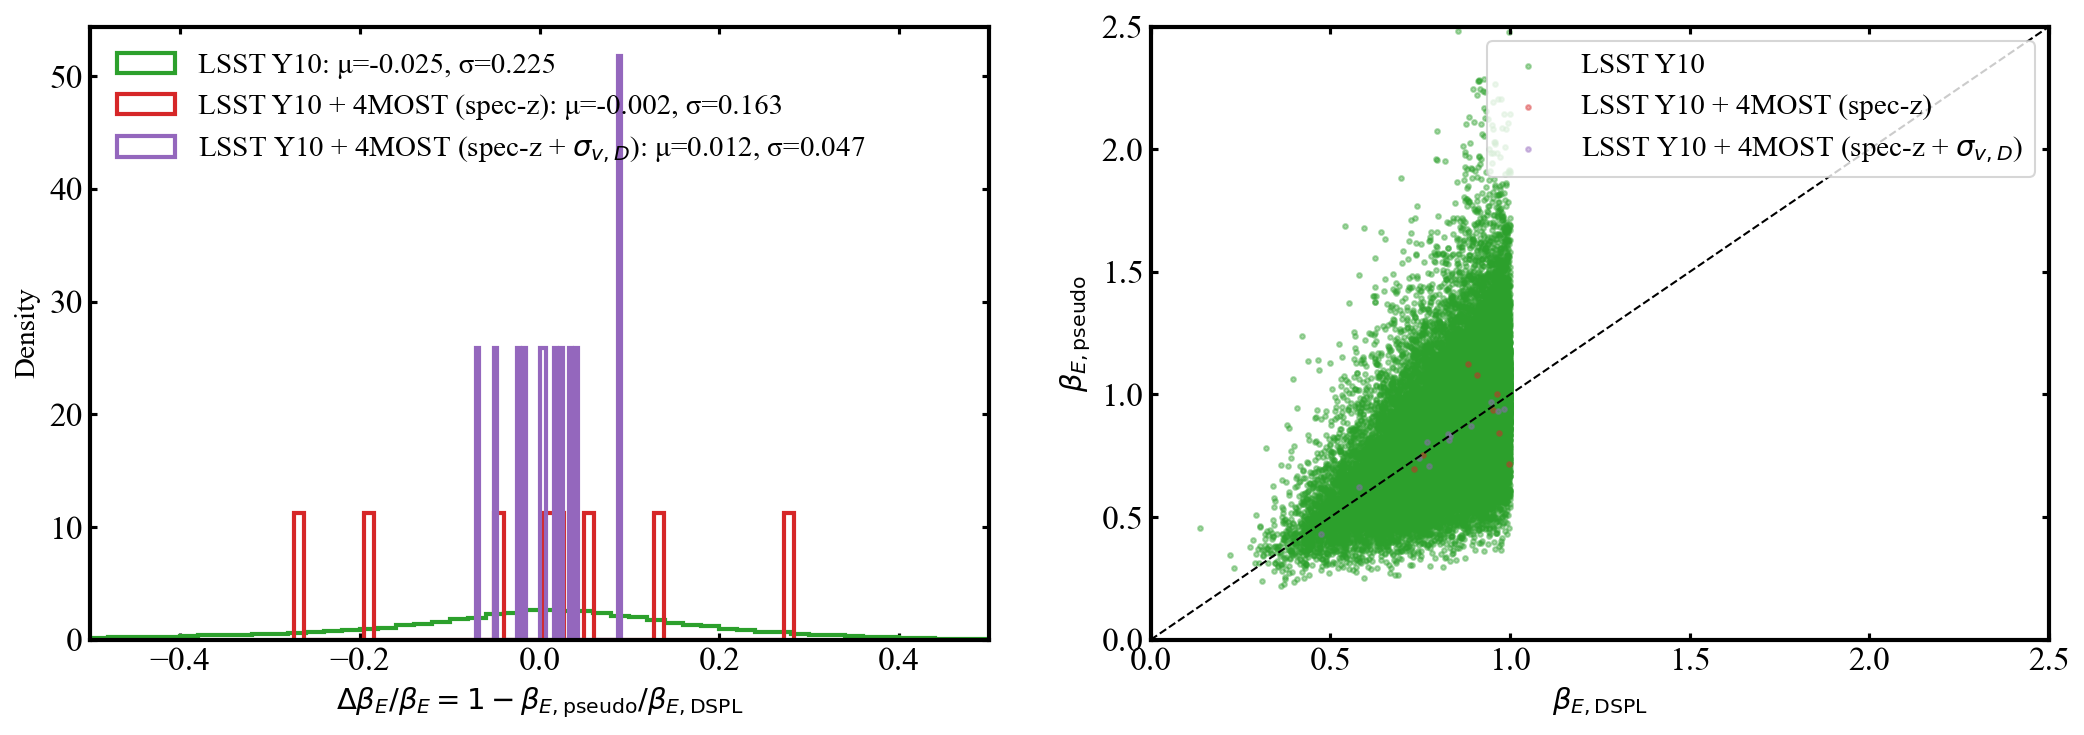

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
ax_hist, ax_scatter = axes

samples_to_plot = ["lsst_y10", 
                   "lsst_4most_spec-z", 
                   "lsst_4most_spec-z_sigma_v"]

for key in samples_to_plot:
    s = pdspl_samples[key]
    beta_DSPL = np.array(s['pairs_analysis']['pairs_table']["beta_E_DSPL"])
    beta_pseudo = np.array(s['pairs_analysis']['pairs_table']["beta_E_pseudo"])
    rel_diff = 1 - beta_pseudo / beta_DSPL

    sample_name = s['name']

    # Gaussian fit
    mu, sigma = np.mean(rel_diff), np.std(rel_diff)
    x_fit = np.linspace(np.min(rel_diff), np.max(rel_diff), 200)
    pdf = norm.pdf(x_fit, mu, sigma)
    
    # cut to range -0.5 to 0.5 for better visualization
    rel_diff = rel_diff[(rel_diff > -0.5) & (rel_diff < 0.5)]

    # Histogram with Gaussian overlay
    ax_hist.hist(
        rel_diff, bins=50, density=True, color=s['color'], linewidth=2, histtype='step',
        label=f"{sample_name}: μ={mu:.3f}, σ={sigma:.3f}"
    )
    # ax_hist.plot(x_fit, pdf, lw=1.5, color=s['color'])

    # Scatter plot
    ax_scatter.scatter(
        beta_DSPL, beta_pseudo, s=5, alpha=0.4, color=s['color'], label=sample_name
    )

# Format hist axis
ax_hist.set_xlabel(r"$\Delta\beta_E / \beta_E = 1 - \beta_{E,\mathrm{pseudo}} / \beta_{E,\mathrm{DSPL}}$", fontsize=14)
ax_hist.set_ylabel("Density", fontsize=14)
ax_hist.set_xlim(-0.5, 0.5)
ax_hist.legend(frameon=False, fontsize=14, loc='upper left')
# ax_hist.set_title("Distribution of relative β_E difference across samples")

# Format scatter axis
# ax_scatter.plot([0, np.max(beta_DSPL)], [0, np.max(beta_DSPL)], 'k--', lw=1, label=r"$y = x$")
ax_scatter.set_xlabel(r"$\beta_{E,\mathrm{DSPL}}$", fontsize=14)
ax_scatter.set_ylabel(r"$\beta_{E,\mathrm{pseudo}}$", fontsize=14)
ax_scatter.set_xlim(0, 2.5)
ax_scatter.set_ylim(0, 2.5)
# ax_scatter.set_title(r"$\beta_E$ comparison across samples")
ax_scatter.legend(frameon=False, fontsize=14)

# add a y=x line
ax_scatter.plot([0, 2.5], [0, 2.5], 'k--', lw=1)
ax_scatter.legend(frameon=True, fontsize=14)

# set tick parameters
ax_hist.tick_params(axis='both', which='major', labelsize=16)
ax_scatter.tick_params(axis='both', which='major', labelsize=16)

fig.tight_layout()

# save the figure
# fig.savefig(f"../figures/slsim_all_samples_beta_E_comparison.pdf", dpi=300)
# plt.savefig(f"../figures/slsim_all_samples_beta_E_comparison.png", dpi=300)

Fit for lsst_y10 (D<=0.06): sigma(D) = 2.726 * D + 0.101
Weighted scatter in beta_E for lsst_y10: 9.0862e-02
Effective number of pairs (N_eff): 46.3
binned weighted scatter in beta_E for lsst_y10:  0.1290833998477783
Fit for lsst_4most_spec-z (D<=0.06): sigma(D) = 1.688 * D + 0.061
Weighted scatter in beta_E for lsst_4most_spec-z: 1.6984e-02
Effective number of pairs (N_eff): 1.5
binned weighted scatter in beta_E for lsst_4most_spec-z:  0.07119750667936521
Fit for lsst_4most_spec-z_sigma_v (D<=0.06): sigma(D) = 0.790 * D + 0.031
Weighted scatter in beta_E for lsst_4most_spec-z_sigma_v: 4.8418e-02
Effective number of pairs (N_eff): 1.6
binned weighted scatter in beta_E for lsst_4most_spec-z_sigma_v:  0.03929727937745893


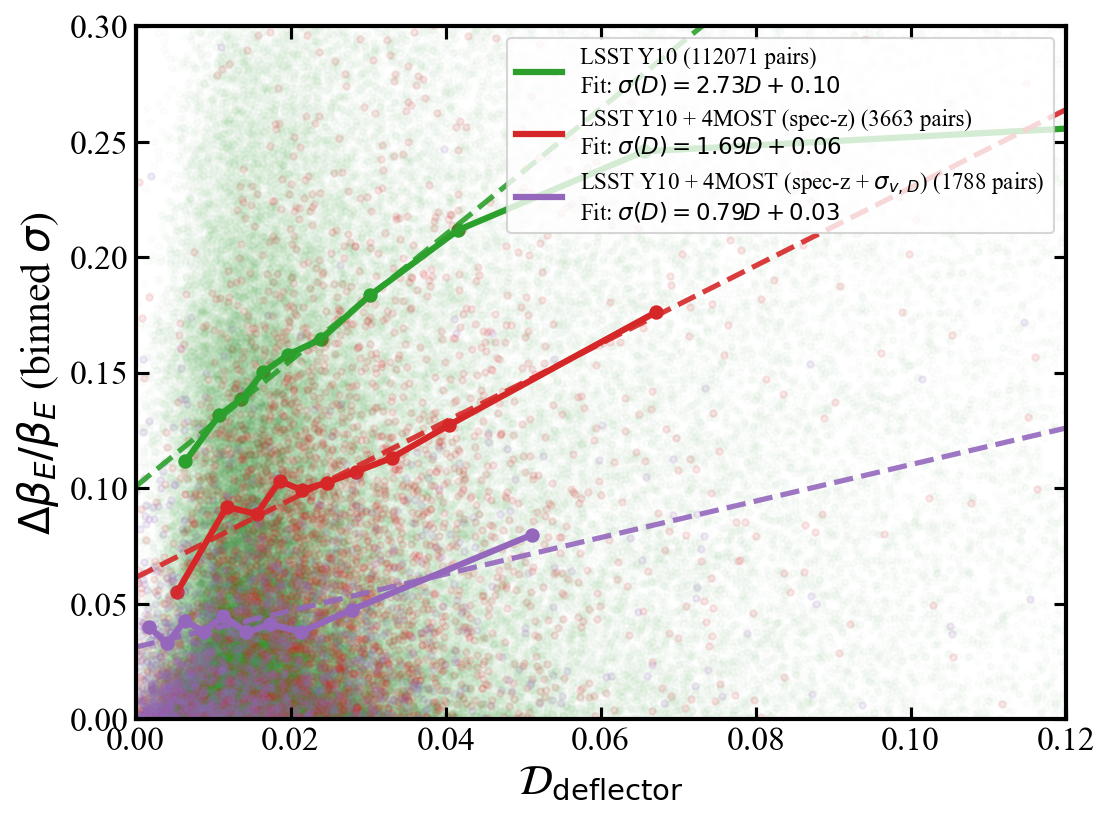

In [ ]:
########################################################
### Define the linear model for fitting
########################################################
def linear_model(x, a, b):
    """
    A simple linear model: f(x) = a*x + b
    We use np.maximum to ensure the uncertainty is never negative.
    """
    return np.maximum(0, a * x + b)

########################################################
### Plot scatter in beta_E vs dissimilarity parameter binned
########################################################
fig, ax = plt.subplots(figsize=(8, 6))

samples_to_plot = ["lsst_y10", 
                   "lsst_4most_spec-z", 
                   "lsst_4most_spec-z_sigma_v"]

tranparencies_scatter_plot = {
    "lsst_y10": 0.01,
    "lsst_4most_spec-z": 0.1,
    "lsst_4most_spec-z_sigma_v": 0.12
}

for key in samples_to_plot:
    s = pdspl_samples[key]
    if "pairs_analysis" not in s:
        print(f"⚠️ Skipping {s['label']} (no pairs_analysis found)")
        continue

    pairs_table = s["pairs_analysis"]["pairs_table"]
    pairs_table_with_errors = s["pairs_analysis"]["pairs_table_with_errors"]
    
    num_pairs = len(pairs_table_with_errors)
    if num_pairs == 0:
        print(f"⚠️ Skipping {s['label']} (no pairs found)")
        continue

    # --- Compute dissimilarity dynamically ---
    diffs = np.array([pairs_table_with_errors[k] for k in s['dissimilarity_keys']])
    estimator = np.sqrt(np.mean(diffs**2, axis=0))

    beta_ratio = pairs_table["beta_E_pseudo"] / pairs_table["beta_E_DSPL"] # these values should be from true table to get the true scatter
    abs_scatter_beta_E = np.abs(1 - beta_ratio)
    scatter_beta_E = 1 - beta_ratio

    # --- Quantile Binning Statistics ---
    n_bins = 10
    quantiles = np.linspace(0, 100, n_bins + 1)
    bins = np.percentile(estimator, quantiles)
    bins = np.unique(bins)
    digitized = np.digitize(estimator, bins)

    # Y-values: std dev of the (1 - ratio) in the bin
    bin_means_y = np.array([
        np.std(1 - beta_ratio[digitized == i]) for i in range(1, len(bins))
    ])
    
    # X-values: The mean dissimilarity (D) in the bin
    bin_means_x = np.array([
        np.mean(estimator[digitized == i]) for i in range(1, len(bins))
    ])

    # Clean NaNs that might arise from empty bins
    valid_mask = ~np.isnan(bin_means_x) & ~np.isnan(bin_means_y)
    bin_means_x_clean = bin_means_x[valid_mask]
    bin_means_y_clean = bin_means_y[valid_mask]

    # --- NEW: Create a mask for the linear fit (D <= 0.06) ---
    fit_mask = bin_means_x_clean <= 0.06
    bin_means_x_for_fit = bin_means_x_clean[fit_mask]
    bin_means_y_for_fit = bin_means_y_clean[fit_mask]
    # --- END NEW ---

    # --- Fit a linear model to the binned statistics (using filtered data) ---
    fit_label_str = "Fit: N/A"
    # Check if we have at least 2 points *to fit*
    if len(bin_means_x_for_fit) > 1: 
        try:
            initial_guess = [1.0, 0.01]
            # Use only the data for fitting (D <= 0.06)
            popt, pcov = curve_fit(linear_model, 
                                   bin_means_x_for_fit, 
                                   bin_means_y_for_fit, 
                                   p0=initial_guess)
            fit_a, fit_b = popt

            # Generate line data for plotting (across the whole range)
            D_line = np.linspace(0, 0.12, 100)
            fit_line = linear_model(D_line, fit_a, fit_b)
            
            # Plot the fitted line as a dashed line
            ax.plot(
                D_line, 
                fit_line, 
                color=s["color"], 
                lw=2.5, 
                ls='--', # Dashed line style
                alpha=0.9
            )
            fit_label_str = f"Fit: $\\sigma(D) = {fit_a:.2f}D + {fit_b:.2f}$"
            print(f"Fit for {key} (D<=0.06): sigma(D) = {fit_a:.3f} * D + {fit_b:.3f}")

        except RuntimeError as e:
            print(f"    ⚠️ Could not fit line for {key}: {e}")
            
    # --- Plotting ---
    
    # Plot the raw scatter plot in the background
    ax.scatter(
        estimator,
        abs_scatter_beta_E,
        color=s["color"],
        s=10,
        alpha=tranparencies_scatter_plot[key], # Very transparent
        label=None # No legend entry for the raw data
    )

    # Plot the binned data (scatter points) - full range
    ax.scatter(
        bin_means_x,
        bin_means_y,
        color=s["color"],
        s=35,
        label=None # No legend entry for the points
    )
    
    # Plot the binned data (solid line) - full range
    # This line will carry the full legend entry
    ax.plot(
        bin_means_x,
        bin_means_y,
        color=s["color"],
        lw=3,
        label=f"{s['name']} ({num_pairs} pairs)\n{fit_label_str}"
    )

    # --- Weighted scatter calculation
    # 
    Neff_bins = 

    # binned weighted scatter
    binned_weighted_scatter = np.sum(bin_means_y / bin_means_x**2) / np.sum(1 / bin_means_x**2)
    print(f"binned weighted scatter in beta_E for {key}: ", binned_weighted_scatter)


# --- Axis formatting ---
ax.set_xlabel(r'$\mathcal{D}_{\rm deflector}$', fontsize=20)
ax.set_ylabel(r'${\Delta \beta_E}/{\beta_E}$ (binned $\sigma$)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16, length=6, width=1.5)
ax.set_xlim(0, 0.12)
ax.set_ylim(0, 0.3)
ax.legend(fontsize=11, frameon=True, loc='upper right')
########################################################

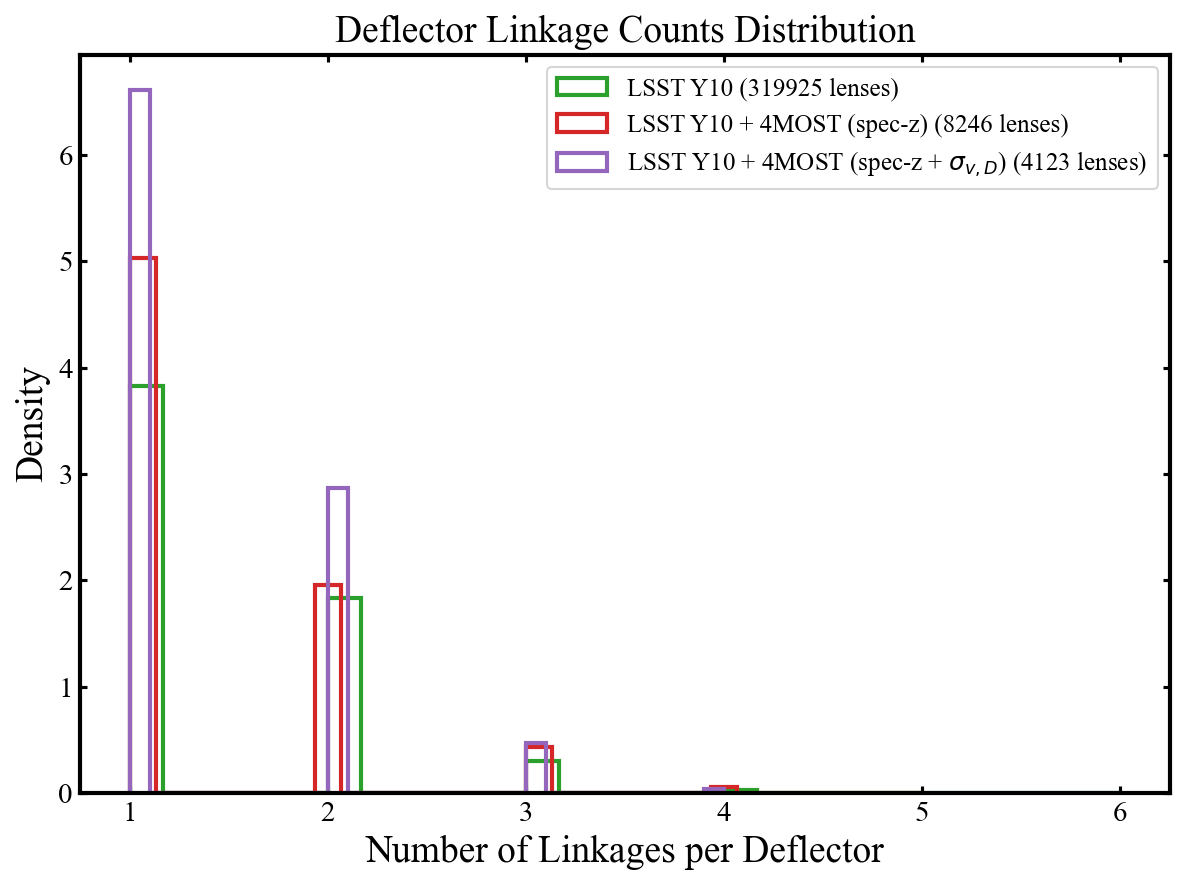

In [68]:
##################################################
###  Histogram of linkage counts
##################################################

samples_to_plot = ["lsst_y10", 
                   "lsst_4most_spec-z", 
                   "lsst_4most_spec-z_sigma_v"]

fig, ax = plt.subplots(figsize=(8, 6))

for key in samples_to_plot:
    s = pdspl_samples[key]
    counts = s['pairs_analysis']['linkage_counts']
    ax.hist(
        counts,
        bins=30,
        density=True,
        histtype='step',
        linewidth=2,
        label=f"{s['name']} ({len(s['table'])} lenses)",
        color=s['color']
    )
ax.set_xlabel("Number of Linkages per Deflector")
ax.set_ylabel("Density")
# ax.set_yscale("log")
ax.set_title("Deflector Linkage Counts Distribution")
ax.legend(fontsize=12)
fig.tight_layout()